# [Jansen-Rit whole brain C++ implementation](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/jansen_rit_cpp.ipynb)


In [44]:
import torch
import pickle
import numpy as np
from tqdm import tqdm
import networkx as nx
import sbi.utils as utils
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sbi.analysis import pairplot
from vbi.inference import Inference
from vbi.models.cpp.jansen_rit import JR_sde
from sklearn.preprocessing import StandardScaler

In [45]:
from vbi import report_cfg
from vbi import extract_features_df
from vbi import get_features_by_domain, get_features_by_given_names
from helpers import *

In [46]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed);

In [47]:
LABESSIZE = 12
plt.rcParams['axes.labelsize'] = LABESSIZE
plt.rcParams['xtick.labelsize'] = LABESSIZE
plt.rcParams['ytick.labelsize'] = LABESSIZE

In [48]:
nn = 6
SC = nx.to_numpy_array(nx.complete_graph(nn))

In [49]:
par = {
    "G": 1.0,
    "noise_mu": 0.24,
    "noise_std": 0.1,
    "dt": 0.05,
    "C0": 135.0 * 1.0,
    "C1": 135.0 * 0.8,
    "C2": 135.0 * 0.25,
    "C3": 135.0 * 0.25,
    "weights": SC,
    "t_transition": 500.0,      # ms
    "t_end": 2501.0,            # ms
    "output": "output",
}

In [50]:
# g, c1[0], c1[2,3]
theta_true = [1.0, 135, 155]

In [51]:
obj = JR_sde(par)
print(obj())

Jansen-Rit sde model
{'G': 1.0, 'A': 3.25, 'B': 22.0, 'a': 0.1, 'b': 0.05, 'noise_mu': 0.24, 'noise_std': 0.1, 'vmax': 0.005, 'v0': 6, 'r': 0.56, 'initial_state': None, 'weights': array([[0., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 0.]]), 'C0': 135.0, 'C1': 108.0, 'C2': 33.75, 'C3': 33.75, 'noise_seed': 0, 'seed': None, 'dt': 0.05, 'dim': 6, 'method': 'heun', 't_transition': 500.0, 't_end': 2501.0, 'output': 'output', 'RECORD_AVG': False}


In [52]:
# C1 needs to be a vector of size nn
C1 = np.ones(nn) * par['C1']
C1[0] = theta_true[1]
C1[[2,3]] = theta_true[2]
theta_true_dict = {"G": 1.0, "C1":C1}
data = obj.run(theta_true_dict)

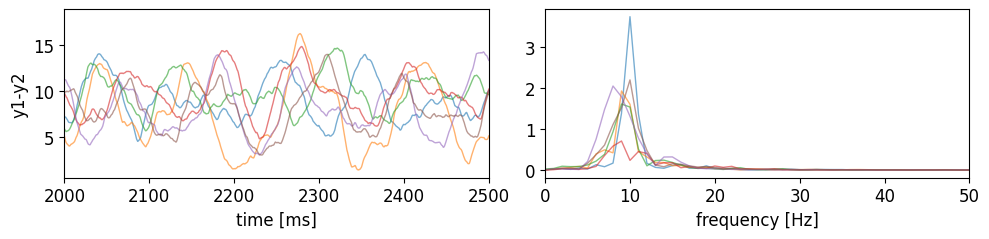

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))
plot_ts_pxx_jr(data, par, [ax[0], ax[1]], alpha=0.6, lw=1)
ax[0].set_xlim(2000, 2500)
plt.tight_layout()

In [54]:
cfg = get_features_by_domain(domain="statistical")
cfg = get_features_by_given_names(cfg, names=['calc_std', 'calc_mean'])
report_cfg(cfg)

Selected features:
------------------
■ Domain: statistical
 ▢ Function:  calc_std
   ▫ description:  Computes the standard deviation of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_std
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes
 ▢ Function:  calc_mean
   ▫ description:  Computes the mean of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_mean
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes


In [55]:
from copy import deepcopy

def wrapper(par, control, cfg, verbose=False):
    g, x1, x2 = control
    par1 = deepcopy(par)
    C1 = np.ones(nn) * par['C1']
    par1['G'] = g
    par1['C1'] = C1
    par1['C1'][0] = x1
    par1['C1'][[2,3]] = x2
    
    ode = JR_sde(par1)
    sol = ode.run()

    # extract features
    fs = 1.0 / par['dt'] * 1000  # [Hz]
    stat_vec = extract_features_df(ts=[sol['x']],
                                      cfg=cfg,
                                      fs=fs,
                                      n_workers=1,
                                      verbose=verbose).values
    return stat_vec[0]

In [56]:
def batch_run(par, control_list, cfg, n_workers=1):
    n = len(control_list)
    def update_bar(_):
        pbar.update()
    with Pool(processes=n_workers) as pool:
        with tqdm(total=n) as pbar:
            async_results = [pool.apply_async(wrapper,
                                              args=(
                                                  par, control_list[i], cfg, False),
                                              callback=update_bar)
                             for i in range(n)]
            stat_vec = [res.get() for res in async_results]
    return stat_vec

In [57]:
x_ = wrapper(par, theta_true, cfg)
print(x_)

[2.0830188 3.294864  2.4442172 2.181784  2.2507007 2.2812603 9.048109
 7.727638  9.848883  9.870417  7.8413916 8.090325 ]


In [58]:
num_sim = 2000
num_workers = 10
C11_min, C11_max = 130.0, 300.0
C12_min, C12_max = 130.0, 300.0
G_min, G_max = 0.0, 5.0
prior_min = [G_min, C11_min, C12_min]
prior_max = [G_max, C11_max, C12_max]
prior = utils.BoxUniform(low=torch.tensor(prior_min),
                         high=torch.tensor(prior_max))

In [59]:
obj = Inference()
theta = obj.sample_prior(prior, num_sim)
theta_np = theta.numpy().astype(float)

In [60]:
stat_vec = batch_run(par, theta_np, cfg, num_workers)

100%|██████████| 2000/2000 [00:36<00:00, 55.03it/s]


In [61]:
scaler = StandardScaler()
stat_vec_st = scaler.fit_transform(np.array(stat_vec))
stat_vec_st = torch.tensor(stat_vec_st, dtype=torch.float32)
torch.save(theta, 'output/theta.pt')
torch.save(stat_vec, 'output/stat_vec.pt')

In [62]:
print(theta.shape, stat_vec_st.shape)

torch.Size([2000, 3]) torch.Size([2000, 12])


In [63]:
posterior = obj.train(theta, stat_vec_st, prior, method="SNPE", density_estimator="maf")

 Neural network successfully converged after 163 epochs.train Done in 0 hours 0 minutes 21.653859 seconds


In [64]:
with open('output/posterior.pkl', 'wb') as f:
    pickle.dump(posterior, f)

In [65]:
xo = wrapper(par, theta_true, cfg)
xo_st = scaler.transform(xo.reshape(1, -1))

In [66]:
samples = obj.sample_posterior(xo_st, 10000, posterior)
torch.save(samples, 'output/samples.pt')

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

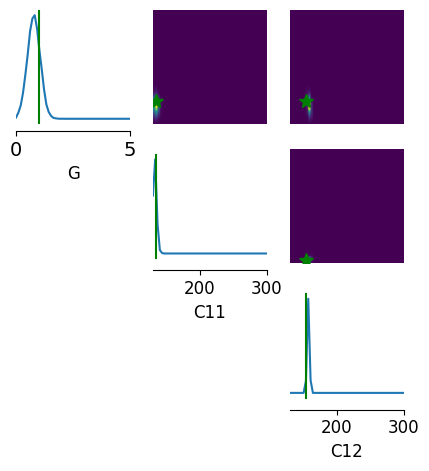

In [71]:
limits = [[i, j] for i, j in zip(prior_min, prior_max)]
points = [theta_true]
fig, ax = pairplot(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=points,
    labels=["G", "C11", "C12"],
    upper="kde",
    diag="kde",
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"],
    ),
)
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].margins(y=0)
fig.savefig("output/jr_sde_cpp.jpeg", dpi=300)